In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter
import sys
from tqdm import tqdm
from functools import partial
import acd
from copy import deepcopy
sys.path.append('..')
sys.path.append('../..')
from transforms_torch import bandpass_filter
# plt.style.use('dark_background')
sys.path.append('../../dsets/mnist')
import dset
from model import Net, Net2c
from util import *
from numpy.fft import *
from torch import nn
from style import *
from captum.attr import (
    InputXGradient,
    Saliency,
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)
import pickle as pkl
from torchvision import datasets, transforms
from sklearn.decomposition import NMF
import transform_wrappers
import visualize as viz
torch.manual_seed(42)
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
sys.path.append('../../..')
# from hierarchical_dnn_interpretations.acd.scores import cd as acd
from acd_wooseok.acd.scores import cd
from acd_wooseok.acd.util import tiling_2d
from knockout_nmf import *

# Dataset

In [3]:
# load args
args = dset.get_args()
args.batch_size = int(args.batch_size/2) # half the batchsize
args.epochs = 2
args.cuda = not args.no_cuda and torch.cuda.is_available()

# load NMF object
# run NMF
# nmf = NMF(n_components=30, max_iter=1000)
# nmf.fit(X)
# pkl.dump(nmf, open('./results/nmf_30.pkl', 'wb'))
nmf = pkl.load(open('./results/nmf_30.pkl', 'rb'))

# Train model

In [4]:
basis_indx = 1
(train_loader, test_loader, interp_loader), data_dict = dataloader_remove_nmf_basis(args, 
                                                                                    nmf, 
                                                                                    basis_indx=basis_indx, 
                                                                                    return_interp_loader=True,
                                                                                    return_indices=True)
# create model
model = Net2c()
if args.cuda:
    model = model.to(device)

# train model
for epoch in range(1, args.epochs + 1):
    model = dset.train(epoch, train_loader, model, args)
    dset.test(model, test_loader, args)

# save
# torch.save(model.state_dict(), 'mnist.model')

Train Epoch: 1 [41920/41990 (100%)]	Loss: 0.311532
Test set: Average loss: 0.2736, Accuracy: 6137/6858 (89%)

Train Epoch: 2 [41920/41990 (100%)]	Loss: 0.157811
Test set: Average loss: 0.1176, Accuracy: 6522/6858 (95%)



# Grad scores

 batch index: 3

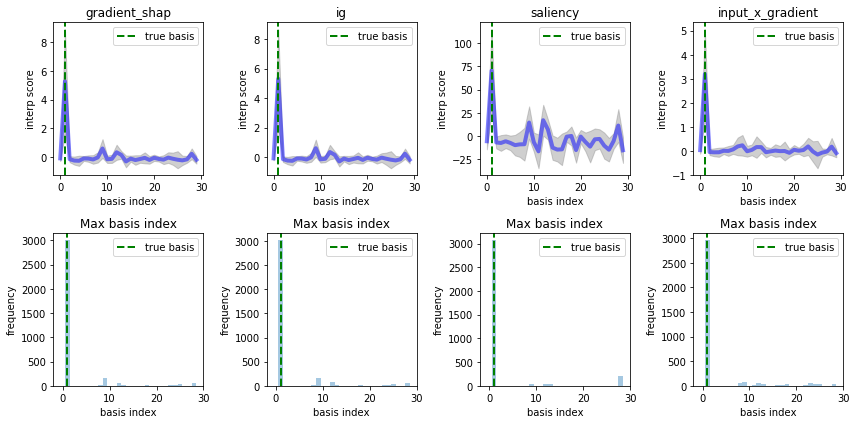

In [15]:
# gradients evaluated at the entire image
results = comp_grad_scores(model, nmf, interp_loader, data_dict, grad_mode='exact')
list_of_x = np.arange(nmf.n_components)
interp_modules = ['gradient_shap', 'ig', 'saliency', 'input_x_gradient']
viz.viz_interp_scores(list_of_x, interp_modules, results, basis_indx=basis_indx)

 batch index: 3

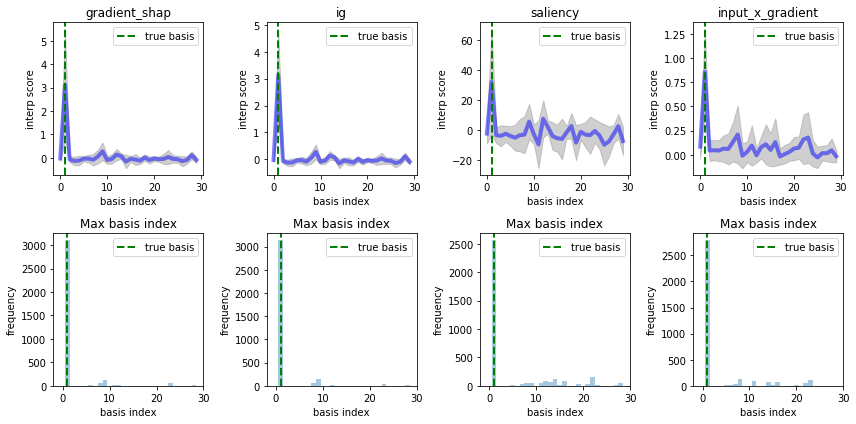

In [17]:
# gradients evaluated at the nmf approximation
results = comp_grad_scores(model, nmf, interp_loader, data_dict, grad_mode='approx')
list_of_x = np.arange(nmf.n_components)
interp_modules = ['gradient_shap', 'ig', 'saliency', 'input_x_gradient']
viz.viz_interp_scores(list_of_x, interp_modules, results, basis_indx=basis_indx)

# CD score

In [23]:
results_cd = comp_cd_scores(model, nmf, interp_loader, data_dict, cd_mode='cd', device='cuda')

 batch index: 3 [basis component index: 29]

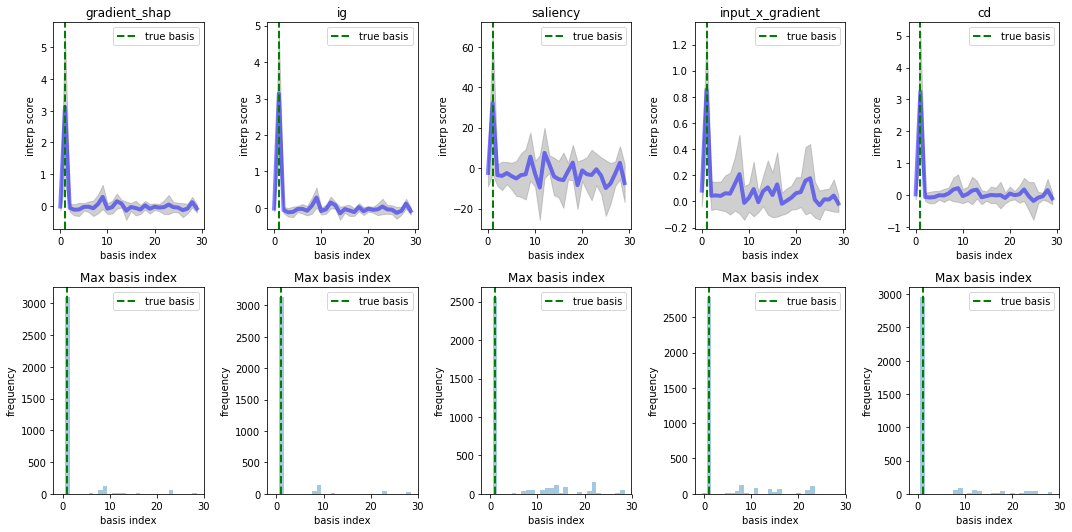

In [27]:
results['cd'] = results_cd['cd']
list_of_x = np.arange(nmf.n_components)
interp_modules = ['gradient_shap', 'ig', 'saliency', 'input_x_gradient', 'cd']
viz.viz_interp_scores(list_of_x, interp_modules, results, basis_indx=basis_indx)